In [1]:
%load_ext autoreload
%autoreload 2

import cudf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.ranker import LGBModel
from src.utils import period_extraction, get_data_period
from src.metrics import ndcg_score
from src.evaluation import get_pred_items, get_ndcg_score

In [2]:
df = pd.read_csv('../data/processed/train.csv', parse_dates=['time_stamp'])
train = pd.read_csv('../data/exp004/features_2017-04-16_t14_e7_n100.csv')
valid = pd.read_csv('../data/exp004/features_2017-04-23_t14_e7_n100.csv')
test = pd.read_csv('../data/exp004/features_2017-04-30_t14_e7_n100.csv')

In [3]:
train['cat'] = train['user_id'].str.split('_', expand=True)[1]
valid['cat'] = valid['user_id'].str.split('_', expand=True)[1]
test['cat'] = test['user_id'].str.split('_', expand=True)[1]

train['cat'] = train['cat'].astype('category')
valid['cat'] = valid['cat'].astype('category')
test['cat'] = test['cat'].astype('category')

In [4]:
model = LGBModel()

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 256,
    'max_bin': 255,
    'max_depth': -1,
    'bagging_freq': 1,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.9,
}

train_params = {
    'num_boost_round':2000,
    'early_stopping_rounds':50,
    'verbose_eval':100,
}

/opt/conda/envs/rapids/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/rapids/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4365
[LightGBM] [Info] Number of data points in the train set: 1201100, number of used features: 25


/opt/conda/envs/rapids/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/envs/rapids/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 0.046945
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.261821	valid_1's rmse: 0.265377
[200]	training's rmse: 0.256068	valid_1's rmse: 0.263279
[300]	training's rmse: 0.252499	valid_1's rmse: 0.262876
[400]	training's rmse: 0.249693	valid_1's rmse: 0.262771
[500]	training's rmse: 0.247368	valid_1's rmse: 0.262755
Early stopping, best iteration is:
[488]	training's rmse: 0.247628	valid_1's rmse: 0.262749


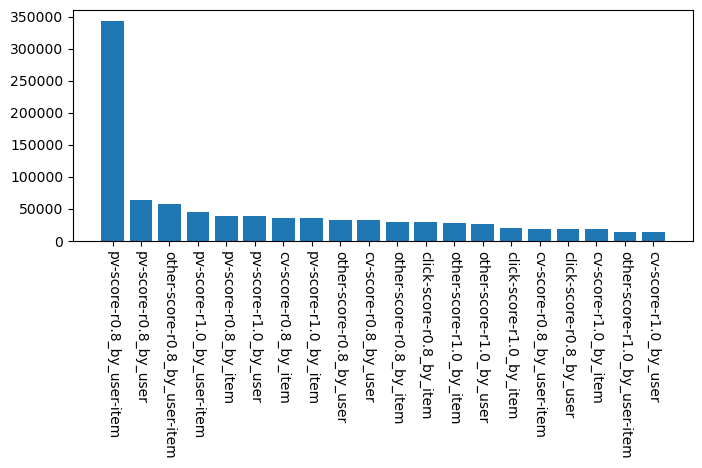

In [5]:
#train = train[train['rated']==1]
#valid = valid[valid['rated']==1]

X_train = train.iloc[:, 4:]
y_train = train['target']
X_valid = valid.iloc[:, 4:]
y_valid = valid['target']
X_test = test.iloc[:, 4:]

model.train(
        params,
        X_train,
        y_train,
        X_valid,
        y_valid,
        train_params=train_params
)

feature_importance = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_,
}).sort_values('importance', ascending=False).head(20)
plt.figure(figsize=(8, 3))
plt.bar(np.arange(len(feature_importance)), feature_importance['importance'])
plt.xticks(np.arange(len(feature_importance)), feature_importance['feature'], rotation=-90)
plt.show()

In [6]:
date_th = '2017-04-23'
train_period = 7
eval_period = 7

y_valid_pred = model.predict(X_valid)
pred_items = get_pred_items(valid[['user_id', 'product_id']], y_valid_pred)
score = get_ndcg_score(
    df,
    pred_items,
    date_th,
    train_period,
    eval_period,
)
print(f'ndcg: {score:.4f}')

ndcg: 0.2303


In [8]:
y_test_pred = model.predict(X_test)
pred_items = get_pred_items(test[['user_id', 'product_id']], y_test_pred)

submission = []
for user, items in pred_items.items():
    for i, item in enumerate(items):
        submission.append([user, item, i])
submission = pd.DataFrame(submission)
submission.to_csv('../data/submission/exp004_cv-0.2303_submission.tsv', sep='\t', index=False, header=False)
print(submission.shape)
submission.head()

(255156, 3)


,0,1,2
0,0000008_A,00006259_a,0
1,0000008_A,00008092_a,1
2,0000008_A,00004596_a,2
3,0000008_A,00006560_a,3
4,0000008_A,00000269_a,4
